<a href="https://colab.research.google.com/github/MattJCR/APRENDIZAJE-NO-SUPERVISADO-KMEANS/blob/master/APRENDIZAJE_NO_SUPERVISADO_KMEANS_Segmentaci%C3%B3n_de_pa%C3%ADses.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Descripción de la tarea 

Realizar estudios exploratorios de los datos usando análisis cluster y empleando el algoritmo de Kmeans o K-medias. Para ello habrá que: 
* Preprocesar los datos. En esta etapa se seleccionarán las variables que sean relevantes, detectará los outliers y observaciones relevantes. 
* Análisis cluster. Se determinará cuántos grupos significativos se pueden encontrar en los datos y se calcularán. 
* Realizar una descripción semántica de los patrones encontrados. analizando la importancia de cada grupo y analizando la importancia de las variables en su definición, para ello hay que realizar una descripción estadística de los grupos encontrados. 

## Segmentación de países 

* https://www.kaggle.com/rohan0301/unsupervised-learning-on-country-data 
* En el dataset se encuentran datos relativos a factores socioeconómicos y de salud que determinan el desarrollo de un país. 
* El objetivo es categorizar los países en base a esos factores socioeconómicos y de salud.

Ideas de visualización:
https://towardsdatascience.com/the-art-of-effective-visualization-of-multi-dimensional-data-6c7202990c57 

In [6]:
#@title Importación de librerías
import pandas as pd
import time
import urllib.request
import tempfile
import seaborn as sns
import numpy as np
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')

In [7]:
#@title Obtención del dataset

# URL del archivo CSV en GitHub
# https://www.kaggle.com/datasets/thedevastator/european-day-ahead-market-power-prices-by-hour

url = 'https://raw.githubusercontent.com/MattJCR/APRENDIZAJE-NO-SUPERVISADO-KMEANS/master/dataset/Country-data.csv'
dfs = []

# Descargar el archivos CSV

response = urllib.request.urlopen(url)

# Crear un archivo temporal para guardar el archivo CSV descargado
temp = tempfile.NamedTemporaryFile()

# Escribir los datos descargados en el archivo temporal
temp.write(response.read())

# Mover el puntero al inicio del archivo
temp.seek(0)

# Cargar el archivo CSV en un DataFrame
df = pd.read_csv(temp, index_col='country')

# Cerrar el archivo temporal
temp.close()
df

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
country,,,,,,,,,
Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200
...,...,...,...,...,...,...,...,...,...
Vanuatu,29.2,46.6,5.25,52.7,2950,2.62,63.0,3.50,2970
Venezuela,17.1,28.5,4.91,17.6,16500,45.90,75.4,2.47,13500
Vietnam,23.3,72.0,6.84,80.2,4490,12.10,73.1,1.95,1310


In [8]:
df.columns

Index(['child_mort', 'exports', 'health', 'imports', 'income', 'inflation',
       'life_expec', 'total_fer', 'gdpp'],
      dtype='object')

# Preprocesamiento y elección de variables relevantes para el estudio.

In [9]:
df.isnull().sum()

child_mort    0
exports       0
health        0
imports       0
income        0
inflation     0
life_expec    0
total_fer     0
gdpp          0
dtype: int64

In [10]:
df.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,38.270060,41.108976,6.815689,46.890215,17144.688623,7.781832,70.555689,2.947964,12964.155689
std,40.328931,27.412010,2.746837,24.209589,19278.067698,10.570704,8.893172,1.513848,18328.704809
min,2.600000,0.109000,1.810000,0.065900,609.000000,-4.210000,32.100000,1.150000,231.000000
25%,8.250000,23.800000,4.920000,30.200000,3355.000000,1.810000,65.300000,1.795000,1330.000000
50%,19.300000,35.000000,6.320000,43.300000,9960.000000,5.390000,73.100000,2.410000,4660.000000
75%,62.100000,51.350000,8.600000,58.750000,22800.000000,10.750000,76.800000,3.880000,14050.000000
max,208.000000,200.000000,17.900000,174.000000,125000.000000,104.000000,82.800000,7.490000,105000.000000


En este caso no se va a realizar ninguna selección de columnas ya que son pocas y ya están preparadas para el entrenamiento.

Una vez tenemos los datos limpios y preparados para trabajar con ellos vamos a proceder a tratar los datos categoricos.
Vamos a utilizar un encoder llamado OneHotEncoder. Esta clase de scikit-learn codifica variables categóricas en una representación binaria utilizando una codificación "one-hot".

Primero obtenemos las columnas que son categoricas:

In [11]:
categorical = list(set(df.columns) - set(df._get_numeric_data().columns))
categorical

[]

In [12]:
# Inicializar el codificador one-hot
encoder = OneHotEncoder()

# Ajusta y transforma la columna categórica en una matriz de codificación one-hot
one_hot = encoder.fit_transform(df[categorical]).toarray()

# Crea un dataframe a partir de la matriz de codificación one-hot
one_hot_df = pd.DataFrame(one_hot, columns=encoder.get_feature_names_out(categorical))
one_hot_df = one_hot_df.astype(bool)
# Eliminar la columna categórica original
df = df.drop(columns=categorical)
one_hot_df

""
0
1
2
3
4
...
162
163
164
165


In [13]:
df

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
country,,,,,,,,,
Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200
...,...,...,...,...,...,...,...,...,...
Vanuatu,29.2,46.6,5.25,52.7,2950,2.62,63.0,3.50,2970
Venezuela,17.1,28.5,4.91,17.6,16500,45.90,75.4,2.47,13500
Vietnam,23.3,72.0,6.84,80.2,4490,12.10,73.1,1.95,1310


<Axes: >

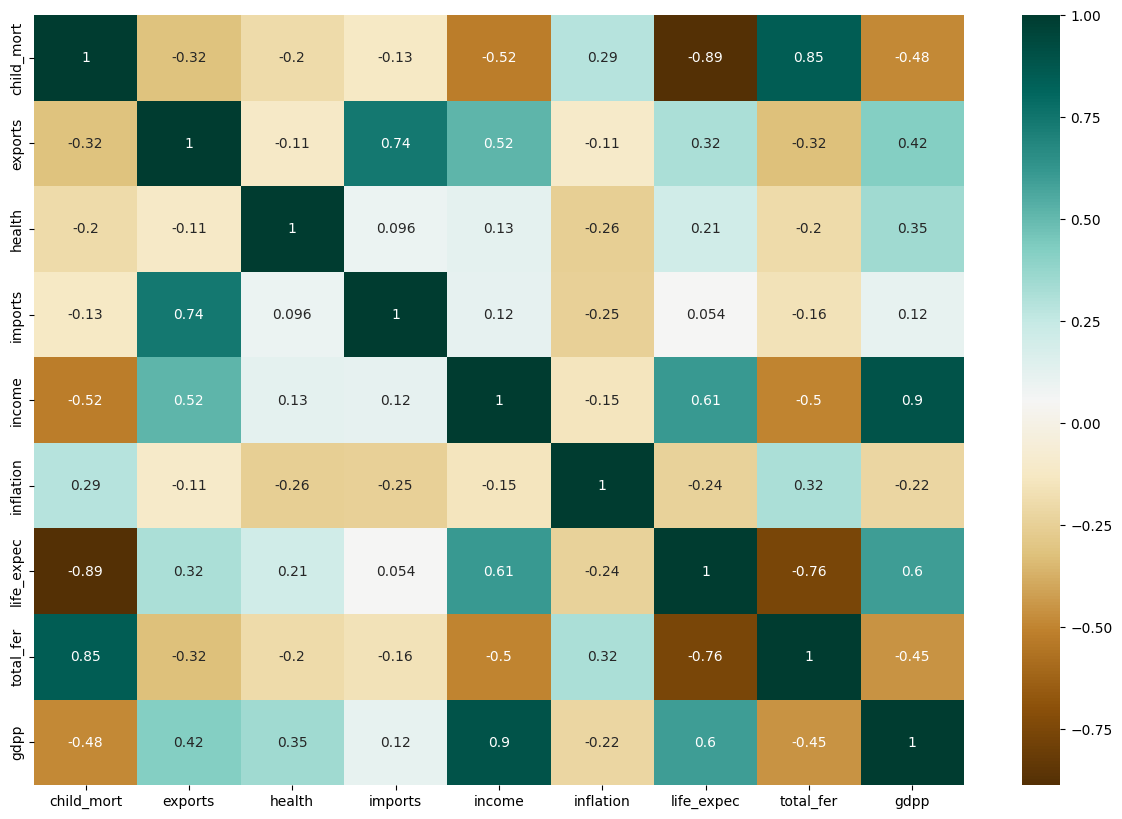

In [14]:
# Calcular la correlación entre las variables del DataFrame
corr = df.corr()

# Mostrar el mapa de calor de la correlación
plt.figure(figsize=(15, 10))
sns.heatmap(df.corr(), cmap = 'BrBG', annot = True)

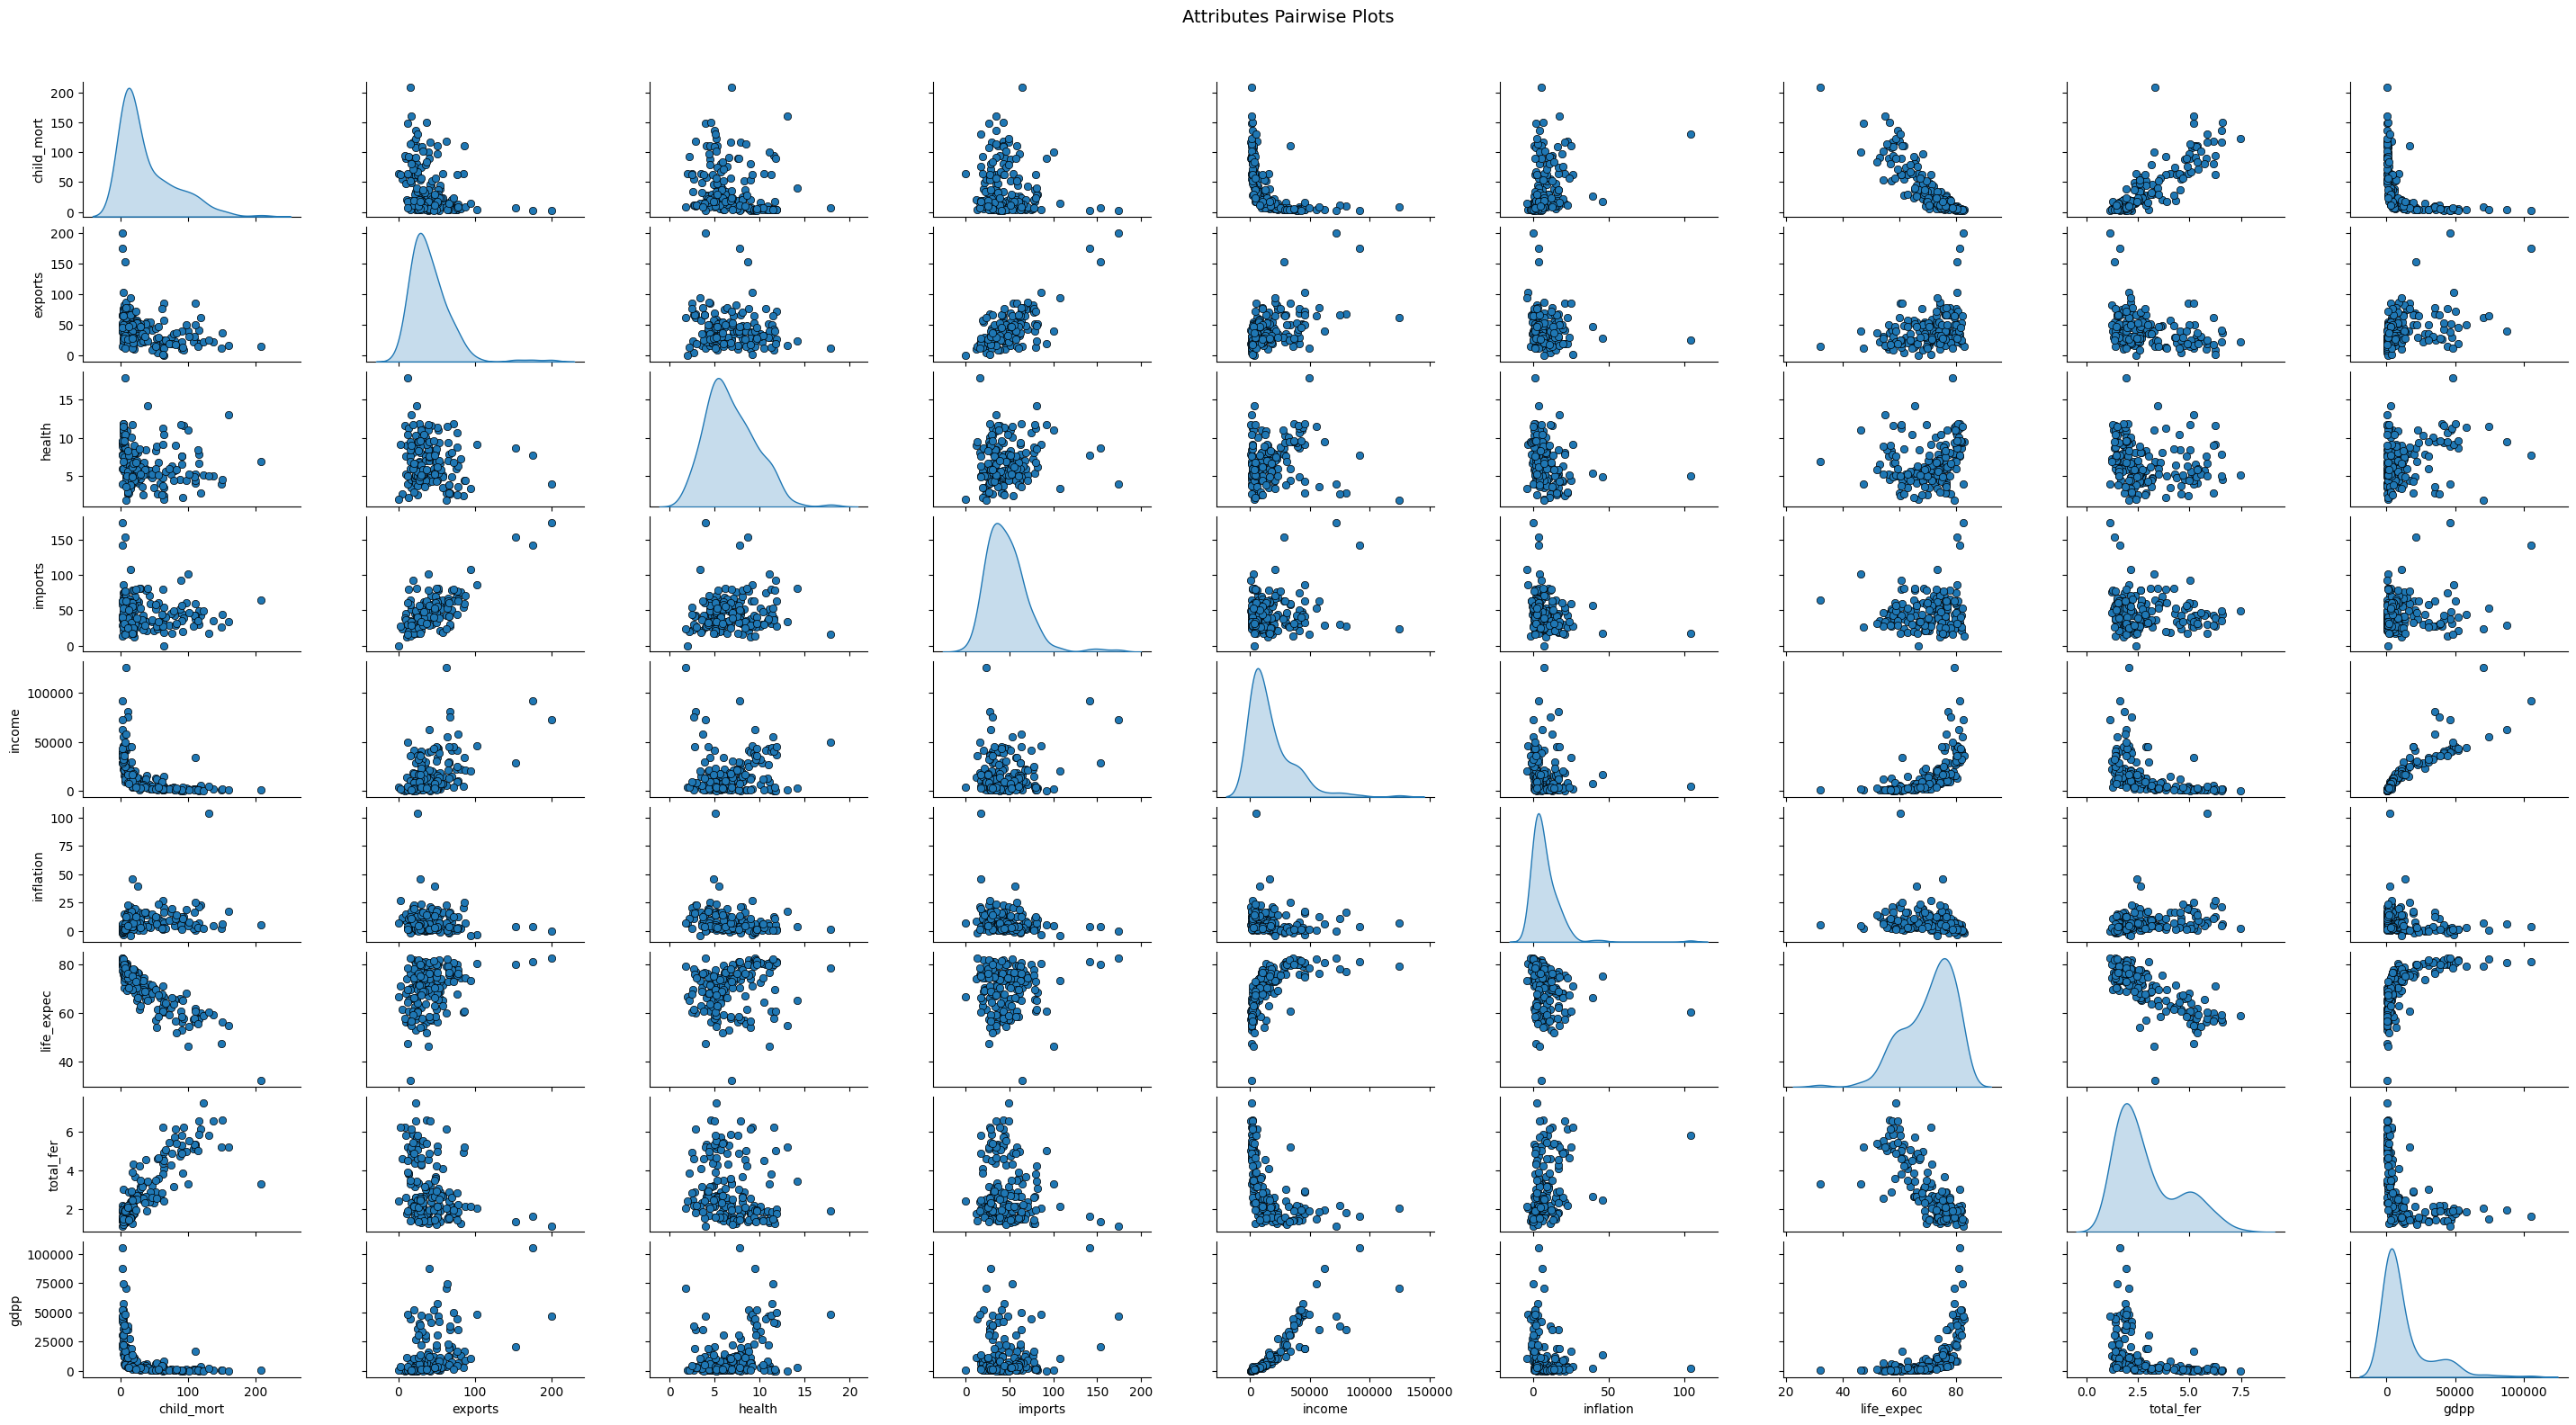

In [15]:
cols = list(df.columns)
pp = sns.pairplot(df[cols], size=1.8, aspect=1.8,
                  plot_kws=dict(edgecolor="k", linewidth=0.5),
                  diag_kind="kde", diag_kws=dict(shade=True))

fig = pp.fig 
fig.subplots_adjust(top=0.93, wspace=0.3)
t = fig.suptitle('Attributes Pairwise Plots', fontsize=14)

array([[<Axes: title={'center': 'child_mort'}>,
        <Axes: title={'center': 'exports'}>,
        <Axes: title={'center': 'health'}>],
       [<Axes: title={'center': 'imports'}>,
        <Axes: title={'center': 'income'}>,
        <Axes: title={'center': 'inflation'}>],
       [<Axes: title={'center': 'life_expec'}>,
        <Axes: title={'center': 'total_fer'}>,
        <Axes: title={'center': 'gdpp'}>]], dtype=object)

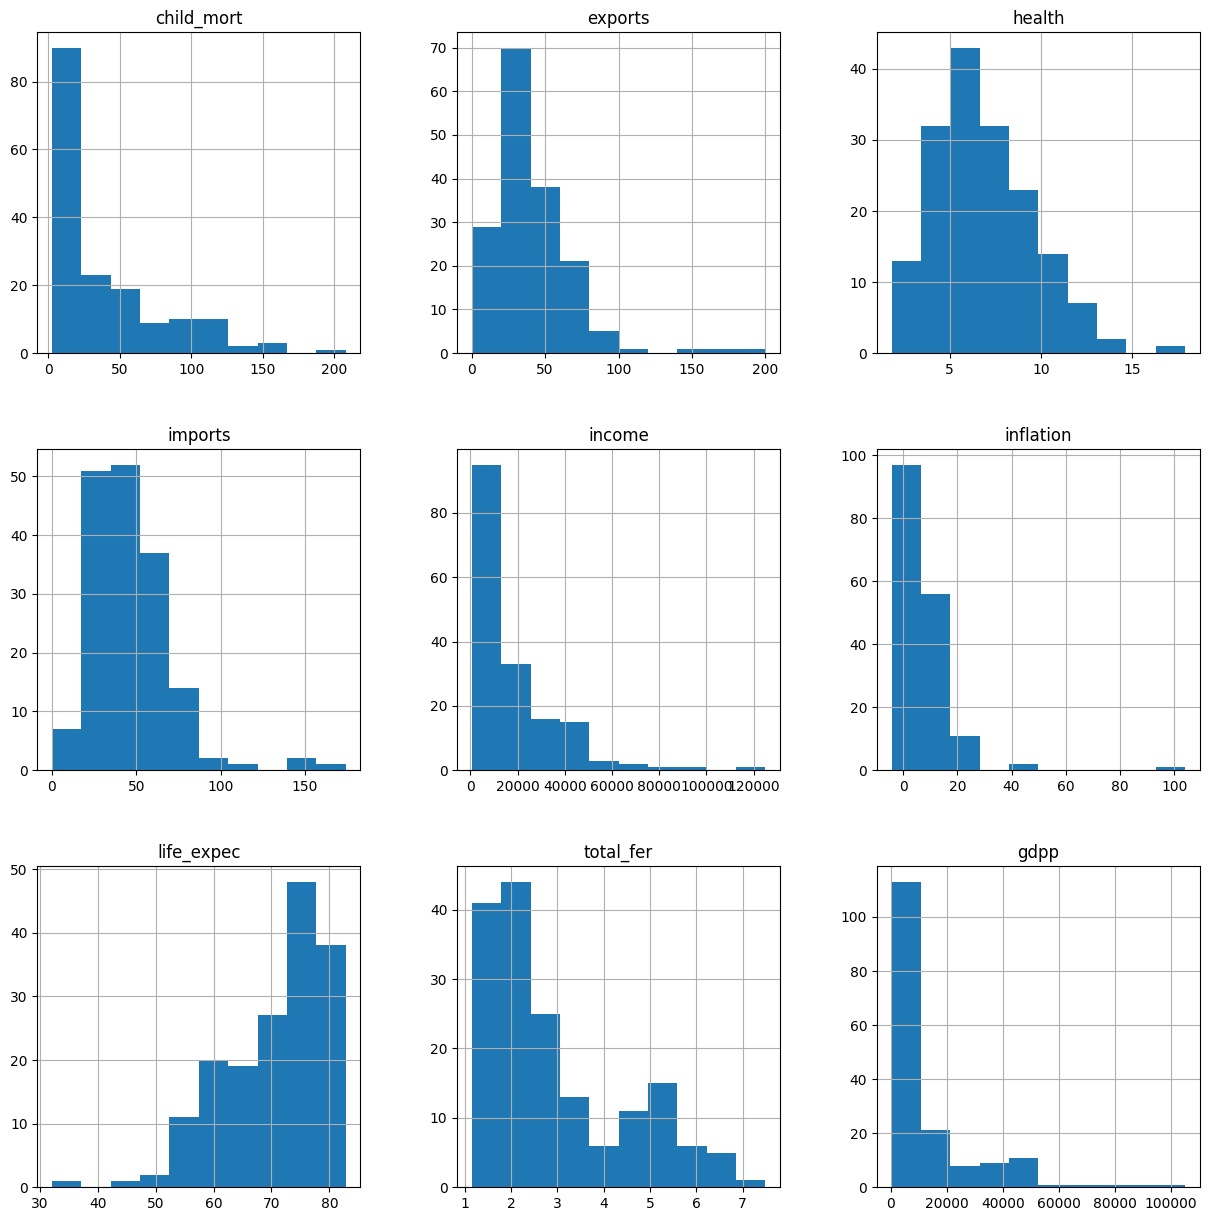

In [16]:
df[df.columns].hist(ax = plt.figure(figsize = (15, 15)).gca())

In [17]:
df

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
country,,,,,,,,,
Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200
...,...,...,...,...,...,...,...,...,...
Vanuatu,29.2,46.6,5.25,52.7,2950,2.62,63.0,3.50,2970
Venezuela,17.1,28.5,4.91,17.6,16500,45.90,75.4,2.47,13500
Vietnam,23.3,72.0,6.84,80.2,4490,12.10,73.1,1.95,1310


# Escalamiento y detección de outliers 

* Argumentar si es necesario o no realizar escalamiento de las variables, y, si es necesario, escalarlas. 

En este caso no es necesario realizar el escalamiento.


In [18]:
# mediante esta función de pueden visualizar los 'outliers'
def draw_hist_boxplot(df, feature_name):
  plt.clf()  # borra la figura anterior
  sns.boxplot(x = feature_name, data = df)
  sns.stripplot(x = feature_name, data = df, color = "#474646")
  plt.show()  # muestra la nueva figura creada

In [19]:
df.columns

Index(['child_mort', 'exports', 'health', 'imports', 'income', 'inflation',
       'life_expec', 'total_fer', 'gdpp'],
      dtype='object')

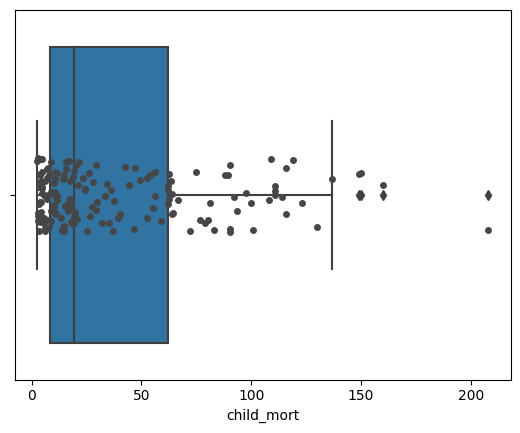

In [20]:
draw_hist_boxplot(df, 'child_mort')

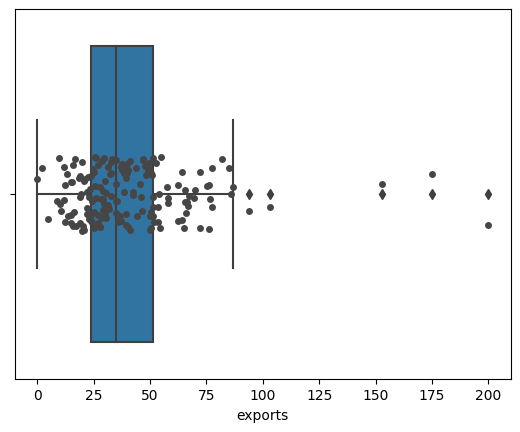

In [21]:
draw_hist_boxplot(df, 'exports')

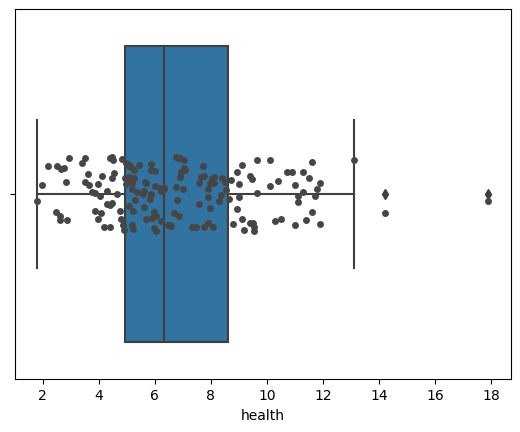

In [22]:
draw_hist_boxplot(df, 'health')

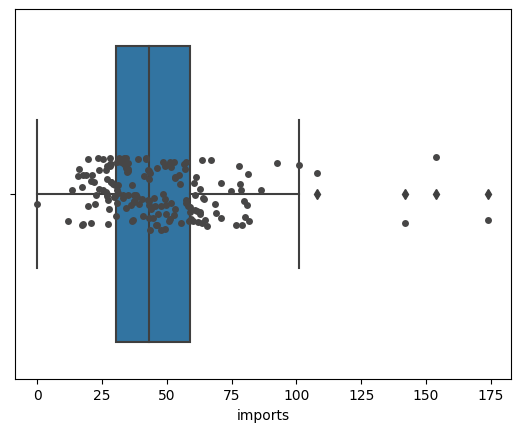

In [23]:
draw_hist_boxplot(df, 'imports')

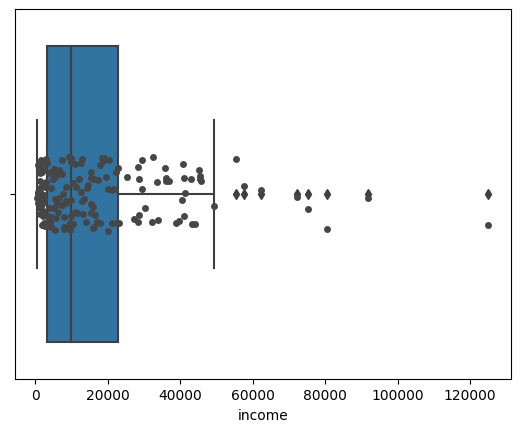

In [24]:
draw_hist_boxplot(df, 'income')

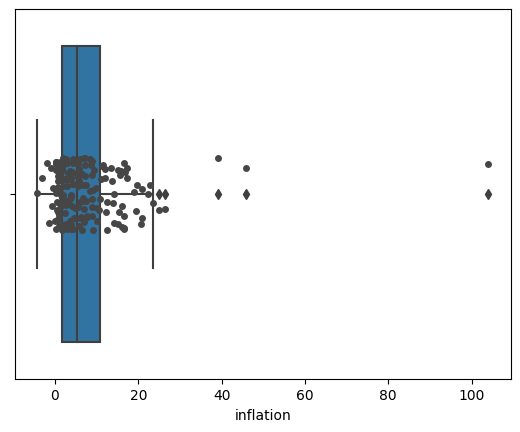

In [25]:
draw_hist_boxplot(df, 'inflation')

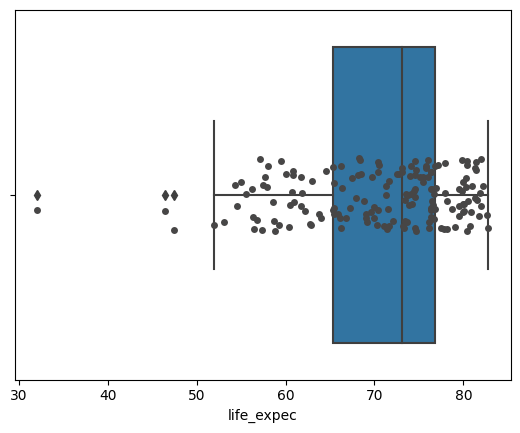

In [26]:
draw_hist_boxplot(df, 'life_expec')

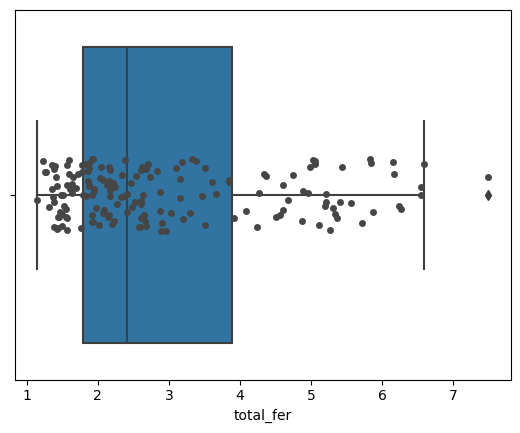

In [27]:
draw_hist_boxplot(df, 'total_fer')

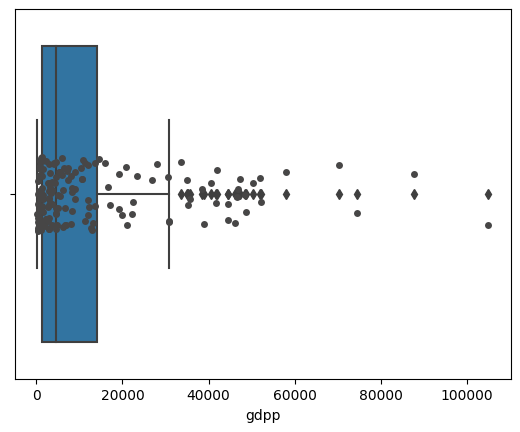

In [28]:
draw_hist_boxplot(df, 'gdpp')

* Detectar los outliers y eliminarlos utilizando el método de Jacknife en el que ejecutaremos el algoritmo K-means eliminando una observación cada vez. 

* Almacenaremos el índice SSE de cada una de las ejecuciones en un vector. Esa información se puede obtener con la variable inertia_ del modelo 


In [29]:
# Convertir dataframe a matriz numpy
X = df.to_numpy()

# Definir parámetros del algoritmo K-means
N = X.shape[0]
K = 4

# Ejecutar el algoritmo K-means con el método de Jacknife
SSE = []
for i in range(0, N):
    X_sin_i = np.delete(X, i, axis=0)
    kmeans = KMeans(n_clusters=K, n_init=10, random_state=100).fit(X_sin_i)
    SSE.append(kmeans.inertia_)

SSE[:5]

[14581555786.64056,
 14596859772.293953,
 14565747703.119827,
 14610219335.70136,
 14539942282.231075]

In [30]:
# Calcular el umbral para detectar outliers
sigma = np.std(SSE)
mu = np.mean(SSE)
umbral = 2

# Identificar los outliers
outliers = []
for i in range(0, N):
    if np.abs(SSE[i]-mu) > umbral*sigma:
        outliers.append(df.index[i])
print(f"Numero de outliers:{len(outliers)}")
outliers

Numero de outliers:7


['Brunei',
 'Kuwait',
 'Luxembourg',
 'Norway',
 'Qatar',
 'Singapore',
 'Switzerland']

In [31]:
# Eliminar los outliers del dataframe
# df = df.drop(outliers)

# Imprimir el dataframe sin los outliers
df

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
country,,,,,,,,,
Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200
...,...,...,...,...,...,...,...,...,...
Vanuatu,29.2,46.6,5.25,52.7,2950,2.62,63.0,3.50,2970
Venezuela,17.1,28.5,4.91,17.6,16500,45.90,75.4,2.47,13500
Vietnam,23.3,72.0,6.84,80.2,4490,12.10,73.1,1.95,1310


* Ejecución de análisis cluster con un valor de k concreto (número de grupos), por ejemplo 4, y determinar el número de réplicas (n_init) del algoritmo que conduce a que la repetición de dicho algoritmo genere la misma solución.

In [32]:
# importar KMeans
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4, n_init = 10, random_state=1)

# entrenamiento (ajustar el modelo)
kmeans.fit(df)
labels = kmeans.labels_

# prediccion -> devuelve array con el número de grupo al que pretenece cada dato
pred = kmeans.predict(df) # También puede utilizarse kmeans.fit_predict(X) realiza ambas etapas

# obtener centroides de los grupos
centroides = kmeans.cluster_centers_
print(centroides)

pred

[[5.41351852e+01 3.32573981e+01 6.32157407e+00 4.55385731e+01
  6.38113889e+03 9.20411111e+00 6.65666667e+01 3.51981481e+00
  3.02725926e+03]
 [1.21028571e+01 5.22942857e+01 6.84514286e+00 4.93371429e+01
  2.56000000e+04 6.59545714e+00 7.60628571e+01 1.97685714e+00
  1.73477143e+04]
 [5.04285714e+00 5.55285714e+01 9.37380952e+00 4.72095238e+01
  4.75714286e+04 2.76814286e+00 8.04571429e+01 1.77761905e+00
  4.60857143e+04]
 [5.00000000e+00 9.23333333e+01 6.35333333e+00 6.47666667e+01
  9.30000000e+04 5.51666667e+00 8.06000000e+01 1.88333333e+00
  8.77000000e+04]]


array([0, 0, 0, 0, 1, 1, 0, 2, 2, 0, 1, 1, 0, 1, 0, 2, 0, 0, 0, 0, 0, 0,
       0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       2, 0, 0, 0, 0, 1, 0, 1, 0, 2, 2, 0, 0, 0, 2, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 2, 0, 0, 0, 0, 2, 1, 2, 0, 2, 0, 1, 0, 0, 2, 0, 0, 1, 0, 0,
       0, 1, 1, 3, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       2, 1, 0, 0, 3, 1, 0, 0, 0, 0, 0, 1, 1, 3, 1, 1, 0, 0, 1, 0, 0, 1,
       0, 2, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 2, 2, 2, 1, 0, 0, 1, 0, 0, 0], dtype=int32)

In [33]:
import plotly.express as px
df_plotly = df.copy()
df_plotly['label'] =  labels
fig = px.scatter_3d(df_plotly, x='life_expec', y='income', z='gdpp',
              color='label')
fig.show()

Determinar el valor de k (número de grupos) 

Optimizando la función BIC

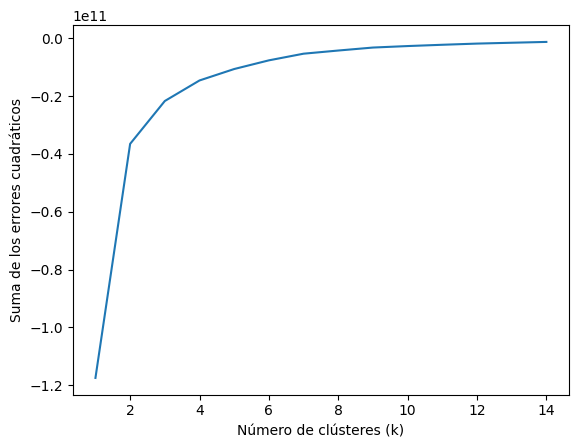

In [34]:
# Curva elbow para determinar valor óptimo de k.
nc = range(1, 15) # El número de iteraciones que queremos hacer.
kmeans = [KMeans(n_clusters=i) for i in nc]
score = [kmeans[i].fit(df).score(df) for i in range(len(kmeans))]
score
plt.xlabel('Número de clústeres (k)')
plt.ylabel('Suma de los errores cuadráticos')
plt.plot(nc,score)

In [35]:
from sklearn.mixture import GaussianMixture
def get_bic(k, X):
    gmm = GaussianMixture(n_components=k, init_params='kmeans')
    gmm.fit(X)
    return k, gmm.bic(X)

In [36]:
bic_score = pd.DataFrame([get_bic(k, X) for k in range(2, 30)], columns=['k', 'BIC'])
bic_score

,k,BIC
0,2,14471.552980
1,3,14390.890623
2,4,14331.868845
3,5,14431.880903
4,6,14228.751448
5,7,14258.412562
6,8,14472.810105
7,9,14392.599233
8,10,14639.211639
9,11,14604.049878


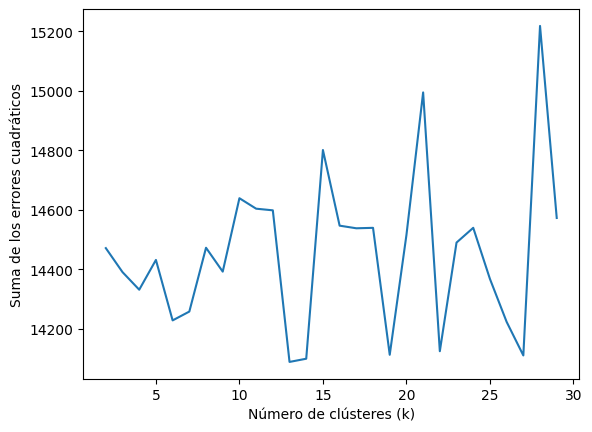

In [37]:
plt.xlabel('Número de clústeres (k)')
plt.ylabel('Suma de los errores cuadráticos')
plt.plot(bic_score['k'],bic_score['BIC'])

In [38]:
k_optimized = bic_score[bic_score.BIC == bic_score.BIC.min()]
k_optimized

,k,BIC
11,13,14089.249693


In [39]:
k = k_optimized['k'].values[0]
k

13

Ejecución de análisis con los datos calculados (k y n_init)

In [42]:
# importar KMeans
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=k, n_init = 10, random_state=1)

# entrenamiento (ajustar el modelo)
kmeans.fit(df)
labels = kmeans.labels_

# prediccion -> devuelve array con el número de grupo al que pretenece cada dato
pred = kmeans.predict(df) # También puede utilizarse kmeans.fit_predict(X) realiza ambas etapas

# obtener centroides de los grupos
centroides = kmeans.cluster_centers_
print(centroides)

pred

[[8.17500000e+00 1.02950000e+02 3.27250000e+00 7.40000000e+01
  7.13750000e+04 1.00885000e+01 7.86250000e+01 1.76750000e+00
  3.88500000e+04]
 [2.29782609e+01 4.16347826e+01 7.03521739e+00 4.35521739e+01
  1.37304348e+04 7.08165217e+00 7.23347826e+01 2.21956522e+00
  6.83043478e+03]
 [5.70000000e+00 3.19000000e+01 8.70857143e+00 3.52571429e+01
  3.08714286e+04 1.18128571e+00 8.00000000e+01 1.82714286e+00
  3.09285714e+04]
 [2.80000000e+00 1.75000000e+02 7.77000000e+00 1.42000000e+02
  9.17000000e+04 3.62000000e+00 8.13000000e+01 1.63000000e+00
  1.05000000e+05]
 [9.00000000e+00 6.23000000e+01 1.81000000e+00 2.38000000e+01
  1.25000000e+05 6.98000000e+00 7.95000000e+01 2.07000000e+00
  7.03000000e+04]
 [8.24039216e+01 2.59940980e+01 6.55784314e+00 4.52973706e+01
  2.23888235e+03 8.97460784e+00 6.11254902e+01 4.54333333e+00
  9.82627451e+02]
 [4.60000000e+00 5.07428571e+01 1.13928571e+01 4.55571429e+01
  4.45857143e+04 7.27428571e-01 8.04714286e+01 1.85571429e+00
  5.09000000e+04]
 [3.85

array([ 5, 11,  1, 11,  8,  8, 11,  6,  6,  1,  2, 10,  5,  8,  1,  9, 11,
        5, 11, 11, 11,  1,  1,  0,  1,  5,  5,  5,  5,  9, 11,  5,  5,  8,
       11,  1,  5,  5, 11,  1,  5,  8,  2, 12,  6,  1, 11, 11, 11, 12,  5,
        8, 11,  9,  9,  1,  5, 11,  9,  5,  2,  1, 11,  5,  5, 11,  5,  8,
        9,  5, 11,  1,  1,  6,  2,  2, 11,  9, 11,  8,  5,  5,  0,  5,  5,
        8,  1,  5,  5, 12,  8,  3,  1,  5,  5,  8,  1,  5, 12,  5,  1,  5,
        5, 11,  1, 11,  5,  5, 11,  5,  6,  2,  5, 11,  7, 10,  5,  1, 11,
       11, 11,  8, 12,  4,  8,  8,  5, 11, 10,  5,  1,  8,  5,  0, 12, 12,
        5,  1, 12,  2, 11, 11,  5,  1,  6,  7,  5,  5,  1,  5,  5, 11, 11,
        8, 11,  5, 11,  0,  9,  6,  8,  5,  5,  8,  5,  5,  5],
      dtype=int32)

In [43]:
import plotly.express as px
df = df.copy()
df['label'] =  labels
fig = px.scatter_3d(df, x='life_expec', y='income', z='gdpp',
              color='label')
fig.show()

In [44]:
df

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,label
country,,,,,,,,,,
Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553,5
Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090,11
Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460,1
Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530,11
Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200,8
...,...,...,...,...,...,...,...,...,...,...
Vanuatu,29.2,46.6,5.25,52.7,2950,2.62,63.0,3.50,2970,5
Venezuela,17.1,28.5,4.91,17.6,16500,45.90,75.4,2.47,13500,8
Vietnam,23.3,72.0,6.84,80.2,4490,12.10,73.1,1.95,1310,5


Mostrar para el análisis anterior una tabla con los siguientes datos: número de grupo, cantidad de observaciones de ese grupo y el centroide que representa a ese grupo(valor de cada variable) 

Esta tabla podría ser una tabla de pandas

In [45]:
group = df.groupby(['label']).count() 
group

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
label,,,,,,,,,
0,4,4,4,4,4,4,4,4,4
1,23,23,23,23,23,23,23,23,23
2,7,7,7,7,7,7,7,7,7
3,1,1,1,1,1,1,1,1,1
4,1,1,1,1,1,1,1,1,1
5,51,51,51,51,51,51,51,51,51
6,7,7,7,7,7,7,7,7,7
7,2,2,2,2,2,2,2,2,2
8,18,18,18,18,18,18,18,18,18


In [46]:
result = []

for idx, x in enumerate(centroides):
    # print(x)
    row = [
        idx, 
        group.loc[[idx]]['child_mort'].values[0],
        x[0],
        x[1],
        x[2],
        x[3],
        x[4],
        x[5],
        x[6],
        x[7],
        x[8]
    ]
    result.append(row)
result = pd.DataFrame(result,columns=['grupo', 'values','center_child_mort','center_exports','center_health','center_imports','center_income','center_inflation','center_life_expec','center_total_fer','center_gdpp'])
result

,grupo,values,center_child_mort,center_exports,center_health,center_imports,center_income,center_inflation,center_life_expec,center_total_fer,center_gdpp
0,0,4,8.175000,102.950000,3.272500,74.000000,71375.000000,10.088500,78.625000,1.767500,38850.000000
1,1,23,22.978261,41.634783,7.035217,43.552174,13730.434783,7.081652,72.334783,2.219565,6830.434783
2,2,7,5.700000,31.900000,8.708571,35.257143,30871.428571,1.181286,80.000000,1.827143,30928.571429
3,3,1,2.800000,175.000000,7.770000,142.000000,91700.000000,3.620000,81.300000,1.630000,105000.000000
4,4,1,9.000000,62.300000,1.810000,23.800000,125000.000000,6.980000,79.500000,2.070000,70300.000000
5,5,51,82.403922,25.994098,6.557843,45.297371,2238.882353,8.974608,61.125490,4.543333,982.627451
6,6,7,4.600000,50.742857,11.392857,45.557143,44585.714286,0.727429,80.471429,1.855714,50900.000000
7,7,2,3.850000,51.850000,10.490000,40.900000,58900.000000,3.133500,81.600000,1.735000,81200.000000
8,8,18,10.872222,47.616667,6.394444,46.661111,19605.555556,7.658333,74.833333,1.873889,11803.888889
9,9,8,4.062500,38.737500,10.372500,37.000000,38712.500000,1.506125,80.987500,1.786250,43212.500000


Realiza una descripción semántica de los grupos

Explicación de las características más relevantes de cada grupo (para ayudarte a explicar los grupos realiza un análisis estadístico de los resultados)

In [47]:
df.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,label
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,38.270060,41.108976,6.815689,46.890215,17144.688623,7.781832,70.555689,2.947964,12964.155689,6.413174
std,40.328931,27.412010,2.746837,24.209589,19278.067698,10.570704,8.893172,1.513848,18328.704809,3.639220
min,2.600000,0.109000,1.810000,0.065900,609.000000,-4.210000,32.100000,1.150000,231.000000,0.000000
25%,8.250000,23.800000,4.920000,30.200000,3355.000000,1.810000,65.300000,1.795000,1330.000000,5.000000
50%,19.300000,35.000000,6.320000,43.300000,9960.000000,5.390000,73.100000,2.410000,4660.000000,5.000000
75%,62.100000,51.350000,8.600000,58.750000,22800.000000,10.750000,76.800000,3.880000,14050.000000,10.500000
max,208.000000,200.000000,17.900000,174.000000,125000.000000,104.000000,82.800000,7.490000,105000.000000,12.000000


In [48]:
#@title GRUPO 0
df[df['label'] == 0].head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,label
country,,,,,,,,,,
Brunei,10.5,67.4,2.84,28.0,80600,16.700,77.1,1.84,35300,0
Kuwait,10.8,66.7,2.63,30.4,75200,11.200,78.2,2.21,38500,0
Singapore,2.8,200.0,3.96,174.0,72100,-0.046,82.7,1.15,46600,0
United Arab Emirates,8.6,77.7,3.66,63.6,57600,12.500,76.5,1.87,35000,0


In [49]:
df[df['label'] == 0].describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,label
count,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.00000,4.000000,4.0
mean,8.175000,102.950000,3.272500,74.000000,71375.000000,10.088500,78.625000,1.76750,38850.000000,0.0
std,3.713377,64.895121,0.638403,68.617588,9832.047939,7.152407,2.806392,0.44455,5404.010856,0.0
min,2.800000,66.700000,2.630000,28.000000,57600.000000,-0.046000,76.500000,1.15000,35000.000000,0.0
25%,7.150000,67.225000,2.787500,29.800000,68475.000000,8.388500,76.950000,1.66750,35225.000000,0.0
50%,9.550000,72.550000,3.250000,47.000000,73650.000000,11.850000,77.650000,1.85500,36900.000000,0.0
75%,10.575000,108.275000,3.735000,91.200000,76550.000000,13.550000,79.325000,1.95500,40525.000000,0.0
max,10.800000,200.000000,3.960000,174.000000,80600.000000,16.700000,82.700000,2.21000,46600.000000,0.0


El grupo 0 está compuesto por paises con una mortalidad infantil baja, baja inflacción y experanza de vida alta.

Tienen un child_mort del 8.6.

Su importación (74) y exportación (102).

Su income es de 71375 netos.

La inflation es 10.

La life_expec es de 78.

El total_fer es 1.7.

Se podria definir como un grupo de paises del primer mundo, en crecimiento y con una buena economia.

In [50]:
#@title GRUPO 1
df[df['label'] == 1].head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,label
country,,,,,,,,,,
Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460,1
Azerbaijan,39.2,54.3,5.88,20.7,16000,13.80,69.1,1.92,5840,1
Belarus,5.5,51.4,5.61,64.5,16200,15.10,70.4,1.49,6030,1
Botswana,52.5,43.6,8.30,51.3,13300,8.92,57.1,2.88,6350,1
Brazil,19.8,10.7,9.01,11.8,14500,8.41,74.2,1.80,11200,1


In [51]:
df[df['label'] == 1].describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,label
count,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.0
mean,22.978261,41.634783,7.035217,43.552174,13730.434783,7.081652,72.334783,2.219565,6830.434783,1.0
std,16.325523,17.190870,1.939496,18.955351,2008.263561,5.776129,6.631921,0.814636,1651.625861,0.0
min,5.500000,10.700000,3.500000,11.800000,10500.000000,0.238000,54.300000,1.400000,4460.000000,1.0
25%,10.600000,30.750000,5.870000,29.400000,12350.000000,2.315000,70.350000,1.590000,5645.000000,1.0
50%,18.600000,39.400000,7.010000,47.900000,13500.000000,5.880000,74.200000,1.920000,6680.000000,1.0
75%,30.850000,51.950000,8.355000,60.500000,15400.000000,11.360000,76.450000,2.595000,8040.000000,1.0
max,63.700000,77.600000,10.900000,78.200000,17400.000000,16.600000,80.400000,4.560000,11200.000000,1.0


El grupo 1 está compuesto por paises con una mortalidad infantil alta, baja inflacción y experanza de vida medio-alta.

Tienen un child_mort del 23.

Su importación (43) y exportación (41).

Su income es de 13730 netos.

La inflation es 7.

La life_expec es de 72.

El total_fer es 2.2.

Se podria definir como un grupo de paises del primer mundo, en crecimiento con mala economia.

In [52]:
#@title GRUPO 2
df[df['label'] == 2].head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,label
country,,,,,,,,,,
Bahamas,13.8,35.0,7.89,43.7,22900,-0.393,73.8,1.86,28000,2
Cyprus,3.6,50.2,5.97,57.5,33900,2.010,79.9,1.42,30800,2
Greece,3.9,22.1,10.30,30.7,28700,0.673,80.4,1.48,26900,2
Israel,4.6,35.0,7.63,32.9,29600,1.770,81.4,3.03,30600,2
Italy,4.0,25.2,9.53,27.2,36200,0.319,81.7,1.46,35800,2


In [53]:
df[df['label'] == 2].describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,label
count,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.0
mean,5.700000,31.900000,8.708571,35.257143,30871.428571,1.181286,80.000000,1.827143,30928.571429,2.0
std,3.679221,9.474175,1.589963,11.412399,4323.083115,1.417309,2.824889,0.604916,3065.786623,0.0
min,3.600000,22.100000,5.970000,26.800000,22900.000000,-0.393000,73.800000,1.370000,26900.000000,2.0
25%,3.850000,25.350000,7.760000,27.600000,29150.000000,0.239500,80.150000,1.440000,29300.000000,2.0
50%,4.000000,30.300000,9.530000,30.700000,32300.000000,0.673000,80.900000,1.480000,30700.000000,2.0
75%,5.400000,35.000000,9.820000,38.300000,33200.000000,1.890000,81.550000,2.015000,32250.000000,2.0
max,13.800000,50.200000,10.300000,57.500000,36200.000000,3.730000,81.900000,3.030000,35800.000000,2.0


El grupo 2 está compuesto por paises con una mortalidad infantil baja, baja inflacción y experanza de vida alta.

Tienen un child_mort del 5.7.

Su importación (35) y exportación (31).

Su income es de 30871 netos.

La inflation es 1.18.

La life_expec es de 80.

El total_fer es 1.8.

Se podria definir como un grupo de paises del primer mundo, en crecimiento con una economia media.

In [54]:
#@title GRUPO 3
df[df['label'] == 3].head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,label
country,,,,,,,,,,
Luxembourg,2.8,175.0,7.77,142.0,91700,3.62,81.3,1.63,105000,3


In [55]:
df[df['label'] == 3].describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,label
count,1.0,1.0,1.00,1.0,1.0,1.00,1.0,1.00,1.0,1.0
mean,2.8,175.0,7.77,142.0,91700.0,3.62,81.3,1.63,105000.0,3.0
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,2.8,175.0,7.77,142.0,91700.0,3.62,81.3,1.63,105000.0,3.0
25%,2.8,175.0,7.77,142.0,91700.0,3.62,81.3,1.63,105000.0,3.0
50%,2.8,175.0,7.77,142.0,91700.0,3.62,81.3,1.63,105000.0,3.0
75%,2.8,175.0,7.77,142.0,91700.0,3.62,81.3,1.63,105000.0,3.0
max,2.8,175.0,7.77,142.0,91700.0,3.62,81.3,1.63,105000.0,3.0


El grupo 3 está compuesto por paises con una mortalidad infantil baja, baja inflacción y experanza de vida alta.

Tienen un child_mort del 2.8.

Su importación (142) y exportación (175).

Su income es de 91700 netos.

La inflation es 3.62.

La life_expec es de 81.

El total_fer es 1.6.

Se podria definir como un grupo de paises del primer mundo, en crecimiento con una economia alta.

In [57]:
#@title GRUPO 4
df[df['label'] == 4].head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,label
country,,,,,,,,,,
Qatar,9.0,62.3,1.81,23.8,125000,6.98,79.5,2.07,70300,4


In [58]:
df[df['label'] == 4].describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,label
count,1.0,1.0,1.00,1.0,1.0,1.00,1.0,1.00,1.0,1.0
mean,9.0,62.3,1.81,23.8,125000.0,6.98,79.5,2.07,70300.0,4.0
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,9.0,62.3,1.81,23.8,125000.0,6.98,79.5,2.07,70300.0,4.0
25%,9.0,62.3,1.81,23.8,125000.0,6.98,79.5,2.07,70300.0,4.0
50%,9.0,62.3,1.81,23.8,125000.0,6.98,79.5,2.07,70300.0,4.0
75%,9.0,62.3,1.81,23.8,125000.0,6.98,79.5,2.07,70300.0,4.0
max,9.0,62.3,1.81,23.8,125000.0,6.98,79.5,2.07,70300.0,4.0


El grupo 4 está compuesto por paises con una mortalidad infantil baja, baja inflacción y experanza de vida alta.

Tienen un child_mort del 9.

Su importación (23) y exportación (62).

Su income es de 125000 netos.

La inflation es 7.

La life_expec es de 79.

El total_fer es 2.

Se podria definir como un grupo de paises del primer mundo, en crecimiento, con una economia alta y con una gran exportación.

In [59]:
#@title GRUPO 5
df[df['label'] == 5].head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,label
country,,,,,,,,,,
Afghanistan,90.2,10.00,7.58,44.9,1610,9.440,56.2,5.82,553,5
Bangladesh,49.4,16.00,3.52,21.8,2440,7.140,70.4,2.33,758,5
Benin,111.0,23.80,4.10,37.2,1820,0.885,61.8,5.36,758,5
Burkina Faso,116.0,19.20,6.74,29.6,1430,6.810,57.9,5.87,575,5
Burundi,93.6,8.92,11.60,39.2,764,12.300,57.7,6.26,231,5


In [60]:
df[df['label'] == 5].describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,label
count,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.0
mean,82.403922,25.994098,6.557843,45.297371,2238.882353,8.974608,61.125490,4.543333,982.627451,5.0
std,38.126862,14.960320,2.826281,21.137897,1117.114473,6.297593,7.238117,1.378236,665.532658,0.0
min,17.200000,0.109000,1.970000,0.065900,609.000000,0.885000,32.100000,1.270000,231.000000,5.0
25%,57.550000,15.650000,4.840000,29.800000,1400.000000,3.835000,57.400000,3.480000,557.500000,5.0
50%,80.300000,22.800000,5.690000,42.700000,1930.000000,7.640000,61.700000,4.870000,769.000000,5.0
75%,104.500000,36.100000,7.780000,55.000000,3005.000000,12.200000,66.150000,5.380000,1300.000000,5.0
max,208.000000,72.000000,14.200000,101.000000,4490.000000,26.500000,73.100000,7.490000,3600.000000,5.0


El grupo 5 está compuesto por paises con una mortalidad infantil alta, baja inflacción y experanza de vida media.

Tienen un child_mort del 82.

Su importación (45) y exportación (25).

Su income es de 2238 netos.

La inflation es 9.

La life_expec es de 61.

El total_fer es 4.5.

Se podria definir como un grupo de paises del primer 3º mundo, en crecimiento, con una economia baja y con mas importación que exportación.

In [61]:
#@title GRUPO 6
df[df['label'] == 6].head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,label
country,,,,,,,,,,
Australia,4.8,19.8,8.73,20.9,41400,1.160,82.0,1.93,51900,6
Austria,4.3,51.3,11.00,47.8,43200,0.873,80.5,1.44,46900,6
Denmark,4.1,50.5,11.40,43.6,44000,3.220,79.5,1.87,58000,6
Ireland,4.2,103.0,9.19,86.5,45700,-3.220,80.4,2.05,48700,6
Netherlands,4.5,72.0,11.90,63.6,45500,0.848,80.7,1.79,50300,6


In [62]:
df[df['label'] == 6].describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,label
count,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.0
mean,4.600000,50.742857,11.392857,45.557143,44585.714286,0.727429,80.471429,1.855714,50900.000000,6.0
std,1.316561,30.635810,3.103910,24.247945,2598.351126,1.929164,1.120587,0.200654,3658.323842,0.0
min,3.000000,12.400000,8.730000,15.800000,41400.000000,-3.220000,78.700000,1.440000,46900.000000,6.0
25%,4.150000,33.000000,9.410000,30.800000,43050.000000,0.860500,79.950000,1.830000,48550.000000,6.0
50%,4.300000,50.500000,11.000000,43.600000,44000.000000,0.991000,80.500000,1.930000,50300.000000,6.0
75%,4.650000,61.650000,11.650000,55.700000,45600.000000,1.190000,81.100000,1.955000,52000.000000,6.0
max,7.300000,103.000000,17.900000,86.500000,49400.000000,3.220000,82.000000,2.050000,58000.000000,6.0


El grupo 6 está compuesto por paises con una mortalidad infantil baja, baja inflacción y experanza de vida alta.

Tienen un child_mort del 4.6.

Su importación (45) y exportación (50).

Su income es de 44585 netos.

La inflation es 0.7.

La life_expec es de 80.

El total_fer es 1.8.

Se podria definir como un grupo de paises del primer mundo, en crecimiento, con una economia media.

In [63]:
#@title GRUPO 7
df[df['label'] == 7].head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,label
country,,,,,,,,,,
Norway,3.2,39.7,9.48,28.5,62300,5.950,81.0,1.95,87800,7
Switzerland,4.5,64.0,11.50,53.3,55500,0.317,82.2,1.52,74600,7


In [64]:
df[df['label'] == 7].describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,label
count,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.0
mean,3.850000,51.850000,10.490000,40.900000,58900.000000,3.133500,81.600000,1.735000,81200.000000,7.0
std,0.919239,17.182695,1.428356,17.536248,4808.326112,3.983132,0.848528,0.304056,9333.809512,0.0
min,3.200000,39.700000,9.480000,28.500000,55500.000000,0.317000,81.000000,1.520000,74600.000000,7.0
25%,3.525000,45.775000,9.985000,34.700000,57200.000000,1.725250,81.300000,1.627500,77900.000000,7.0
50%,3.850000,51.850000,10.490000,40.900000,58900.000000,3.133500,81.600000,1.735000,81200.000000,7.0
75%,4.175000,57.925000,10.995000,47.100000,60600.000000,4.541750,81.900000,1.842500,84500.000000,7.0
max,4.500000,64.000000,11.500000,53.300000,62300.000000,5.950000,82.200000,1.950000,87800.000000,7.0


El grupo 7 está compuesto por paises con una mortalidad infantil baja, baja inflacción y experanza de vida alta.

Tienen un child_mort del 3.8.

Su importación (40) y exportación (51).

Su income es de 58900 netos.

La inflation es 3.1.

La life_expec es de 81.

El total_fer es 1.7.

Se podria definir como un grupo de paises del primer mundo, en crecimiento, con una economia media.

In [67]:
#@title GRUPO 8
df[df['label'] == 8].head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,label
country,,,,,,,,,,
Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.440,76.8,2.13,12200,8
Argentina,14.5,18.9,8.10,16.0,18700,20.900,75.8,2.37,10300,8
Barbados,14.2,39.5,7.97,48.7,15300,0.321,76.7,1.78,16000,8
Chile,8.7,37.7,7.96,31.3,19400,8.960,79.1,1.88,12900,8
Croatia,5.5,37.6,7.76,38.1,20100,0.821,76.3,1.55,13500,8


In [66]:
df[df['label'] == 8].describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,label
count,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.0
mean,10.872222,47.616667,6.394444,46.661111,19605.555556,7.658333,74.833333,1.873889,11803.888889,8.0
std,4.972726,23.309610,1.503585,24.720274,2203.866181,11.699077,2.750615,0.405523,2008.517565,0.0
min,4.500000,18.900000,3.400000,16.000000,15300.000000,-4.210000,68.400000,1.250000,8230.000000,8.0
25%,6.525000,30.050000,5.205000,26.600000,18075.000000,1.495000,73.475000,1.555000,10700.000000,8.0
50%,10.150000,39.800000,6.710000,40.450000,19750.000000,2.955000,75.600000,1.830000,11950.000000,8.0
75%,14.350000,62.400000,7.685000,65.125000,21100.000000,8.537500,76.375000,2.150000,13050.000000,8.0
max,21.500000,93.800000,8.350000,108.000000,23100.000000,45.900000,79.100000,2.600000,16000.000000,8.0


El grupo 8 está compuesto por paises con una mortalidad infantil baja, medio-baja inflacción y experanza de vida alta.

Tienen un child_mort del 10.

Su importación (46) y exportación (47).

Su income es de 19605 netos.

La inflation es 7.

La life_expec es de 74.

El total_fer es 1.9.

Se podria definir como un grupo de paises del primer mundo, en crecimiento, con una economia medio-baja.

In [68]:
#@title GRUPO 9
df[df['label'] == 9].head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,label
country,,,,,,,,,,
Belgium,4.5,76.4,10.70,74.7,41100,1.880,80.0,1.86,44400,9
Canada,5.6,29.1,11.30,31.0,40700,2.870,81.3,1.63,47400,9
Finland,3.0,38.7,8.95,37.4,39800,0.351,80.0,1.87,46200,9
France,4.2,26.8,11.90,28.1,36900,1.050,81.4,2.03,40600,9
Germany,4.2,42.3,11.60,37.1,40400,0.758,80.1,1.39,41800,9


In [69]:
df[df['label'] == 9].describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,label
count,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.00000,8.0
mean,4.062500,38.737500,10.372500,37.000000,38712.500000,1.506125,80.987500,1.786250,43212.50000,9.0
std,1.062258,19.108856,1.139684,17.575795,2130.350407,2.118627,1.054836,0.292621,2895.03886,0.0
min,2.600000,15.000000,8.950000,13.600000,35800.000000,-1.900000,80.000000,1.390000,38900.00000,9.0
25%,3.150000,27.850000,9.467500,30.125000,36725.000000,0.656250,80.075000,1.570000,41500.00000,9.0
50%,4.200000,33.900000,10.170000,34.050000,39300.000000,1.310000,80.800000,1.865000,43150.00000,9.0
75%,4.675000,45.075000,11.375000,38.875000,40475.000000,2.127500,81.550000,1.947500,44925.00000,9.0
max,5.600000,76.400000,11.900000,74.700000,41100.000000,5.470000,82.800000,2.200000,47400.00000,9.0


El grupo 9 está compuesto por paises con una mortalidad infantil baja, medio-baja inflacción y experanza de vida alta.

Tienen un child_mort del 4.

Su importación (37) y exportación (38).

Su income es de 38712 netos.

La inflation es 1.5.

La life_expec es de 80.

El total_fer es 1.7.

Se podria definir como un grupo de paises del primer mundo, en crecimiento, con una economia media.

In [70]:
#@title GRUPO 10
df[df['label'] == 10].head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,label
country,,,,,,,,,,
Bahrain,8.6,69.5,4.97,50.9,41100,7.44,76.0,2.16,20700,10
Oman,11.7,65.7,2.77,41.2,45300,15.60,76.1,2.90,19300,10
Saudi Arabia,15.7,49.6,4.29,33.0,45400,17.20,75.1,2.96,19300,10


In [71]:
df[df['label'] == 10].describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,label
count,3.000000,3.000000,3.00000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.0
mean,12.000000,61.600000,4.01000,41.700000,43933.333333,13.413333,75.733333,2.673333,19766.666667,10.0
std,3.559494,10.564563,1.12641,8.960469,2454.248018,5.234552,0.550757,0.445571,808.290377,0.0
min,8.600000,49.600000,2.77000,33.000000,41100.000000,7.440000,75.100000,2.160000,19300.000000,10.0
25%,10.150000,57.650000,3.53000,37.100000,43200.000000,11.520000,75.550000,2.530000,19300.000000,10.0
50%,11.700000,65.700000,4.29000,41.200000,45300.000000,15.600000,76.000000,2.900000,19300.000000,10.0
75%,13.700000,67.600000,4.63000,46.050000,45350.000000,16.400000,76.050000,2.930000,20000.000000,10.0
max,15.700000,69.500000,4.97000,50.900000,45400.000000,17.200000,76.100000,2.960000,20700.000000,10.0


El grupo 10 está compuesto por paises con una mortalidad infantil medio-baja, medio-baja inflacción y experanza de vida medio-alta.

Tienen un child_mort del 12.

Su importación (41) y exportación (61).

Su income es de 44000 netos.

La inflation es 13.

La life_expec es de 75.

El total_fer es 2.6.

Se podria definir como un grupo de paises del primer mundo, en crecimiento, con una economia medio-alta.

In [72]:
#@title GRUPO 11
df[df['label'] == 11].head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,label
country,,,,,,,,,,
Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090,11
Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530,11
Armenia,18.1,20.8,4.40,45.3,6700,7.77,73.3,1.69,3220,11
Belize,18.8,58.2,5.20,57.5,7880,1.14,71.4,2.71,4340,11
Bhutan,42.7,42.5,5.20,70.7,6420,5.99,72.1,2.38,2180,11


In [73]:
df[df['label'] == 11].describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,label
count,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.0
mean,32.808824,38.485294,5.484412,47.244118,7622.941176,10.984147,70.826471,2.864118,3521.470588,11.0
std,27.073663,16.619834,1.981931,15.167633,1731.973002,18.256741,5.143829,1.130227,988.899395,0.0
min,6.900000,12.400000,2.460000,17.400000,4980.000000,0.505000,58.600000,1.310000,1980.000000,11.0
25%,18.100000,26.900000,4.517500,36.375000,6030.000000,3.715000,69.225000,2.177500,2830.000000,11.0
50%,24.100000,32.450000,5.140000,50.350000,7530.000000,5.860000,71.600000,2.655000,3270.000000,11.0
75%,34.925000,48.175000,6.530000,57.000000,9440.000000,9.552500,74.325000,3.197500,4290.000000,11.0
max,130.000000,85.100000,11.100000,79.100000,10400.000000,104.000000,77.900000,6.160000,6230.000000,11.0


El grupo 11 está compuesto por paises con una mortalidad infantil medio-alta, medio-baja inflacción y experanza de vida medio-alta.

Tienen un child_mort del 31.

Su importación (47) y exportación (38).

Su income es de 7622 netos.

La inflation es 10.

La life_expec es de 70.

El total_fer es 2.8.

Se podria definir como un grupo de paises del primer segundo mundo, en crecimiento, con una economia baja y una mortalidad inflatil medio baja.

In [74]:
#@title GRUPO 12
df[df['label'] == 12].head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,label
country,,,,,,,,,,
Czech Republic,3.4,66.0,7.88,62.9,28300,-1.430,77.5,1.51,19800,12
Equatorial Guinea,111.0,85.8,4.48,58.9,33700,24.900,60.9,5.21,17100,12
Libya,16.6,65.6,3.88,42.1,29600,14.200,76.1,2.41,12100,12
Malta,6.8,153.0,8.65,154.0,28300,3.830,80.3,1.36,21100,12
Portugal,3.9,29.9,11.00,37.4,27200,0.643,79.8,1.39,22500,12


In [75]:
df[df['label'] == 12].describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,label
count,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.0
mean,19.500000,73.787500,7.627500,67.775000,28925.000000,5.600125,76.212500,2.013750,19337.500000,12.0
std,37.232129,36.181662,2.433362,37.242209,2481.790828,9.251108,6.460305,1.341385,3823.587508,0.0
min,3.200000,29.900000,3.880000,37.400000,25200.000000,-1.430000,60.900000,1.230000,12100.000000,12.0
25%,3.775000,60.575000,6.317500,45.175000,28025.000000,0.117000,75.950000,1.382500,16975.000000,12.0
50%,5.450000,65.800000,8.265000,60.900000,28500.000000,1.901500,78.500000,1.470000,20450.000000,12.0
75%,9.400000,78.675000,8.945000,66.625000,29800.000000,6.422500,79.875000,1.780000,22200.000000,12.0
max,111.000000,153.000000,11.000000,154.000000,33700.000000,24.900000,80.300000,5.210000,23400.000000,12.0


El grupo 12 está compuesto por paises con una mortalidad infantil alta, medio-baja inflacción y experanza de vida medio-alta.

Tienen un child_mort del 19.

Su importación (67) y exportación (73).

Su income es de 28925 netos.

La inflation es 5.6.

La life_expec es de 76.

El total_fer es 2.

Se podria definir como un grupo de paises del tercer mundo, en crecimiento, con una economia media y medio-alta mortalidad infantil.